In [1]:
!pip install CFEDemands --upgrade
!pip install xarray
!pip install dvc
!pip install --upgrade oauth2client 

Requirement already up-to-date: CFEDemands in /opt/conda/lib/python3.8/site-packages (0.2.7)


Requirement already up-to-date: oauth2client in /opt/conda/lib/python3.8/site-packages (4.1.3)


## (#A) Estimate Demand System

Estimate a system of demands for different kinds of food. Characterize how consumption varies with household need.

In [2]:
#Nigeria consumption (own production) dataset

Nigeria_Data = '17L5cDhXRLNAckP3JvBLTLSYIguFqP2ebMvQLH96c0n4'

Retrieve data from google sheets using private keys:

In [3]:
import pandas as pd
import numpy as np
from eep153_tools import read_sheets

#### Need private keys from json file (we're authenticating using "service accounts")
!gpg --batch --passphrase "noodle octopus" -d ./students-9093fa174318.json.gpg > ./students-9093fa174318.json
####

# Add credentials if sheet not meant to be public
exp_df = read_sheets(Nigeria_Data,sheet='Expenditures',json_creds='./students-9093fa174318.json')
                 
# Change 'ICRISAT' to key of your own sheet in Sheets, above
household_df = read_sheets(Nigeria_Data,sheet="HH Characteristics",json_creds='./students-9093fa174318.json')

# # Assume a single market by setting m = 1 for all
exp_df.insert(loc=2, column='m', value=1)
household_df.insert(loc=2, column='m', value=1)

gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


### Data Cleaning and filter data by our chosen population (below poverty line)

In [4]:
exp_df = exp_df.replace(0,np.nan) # Replace zeroes with np.nan

#Convert all value types to float64
for i in range(3, len(exp_df.columns)):
    exp_df.iloc[:, i:] = exp_df.iloc[:, i:].astype('float64')

In [5]:
exp_df = exp_df.replace(0.0,np.nan) # Replace zeroes with np.nan
household_df.set_index(['j','t','m'], inplace=True)

#### Create total expenditure column and filter expenditure dataframe by our condition

In [6]:
exp_df['Total expenditure'] = exp_df.iloc[:, 3:].sum(axis=1)
pd.DataFrame(exp_df['Total expenditure'])

,Total expenditure
0,20225.0
1,15365.0
2,4675.0
3,4465.0
4,7565.0
...,...
19136,31100.0
19137,6410.0
19138,20540.0
19139,22650.0


#### Food Expenditure Dataframe (All)

In [7]:
#t = period
#j = idx
#m = market
exp_df

,t,j,m,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,...,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots,Total expenditure
0,2010,10001,1,NaN,280.0,NaN,NaN,NaN,NaN,200.0,...,NaN,150.0,150.0,NaN,NaN,600.0,NaN,NaN,1500.0,20225.0
1,2010,10002,1,NaN,280.0,NaN,NaN,NaN,NaN,180.0,...,140.0,240.0,120.0,NaN,NaN,400.0,NaN,NaN,1200.0,15365.0
2,2010,10003,1,NaN,180.0,NaN,NaN,NaN,NaN,100.0,...,60.0,90.0,100.0,NaN,NaN,100.0,NaN,NaN,400.0,4675.0
3,2010,10004,1,NaN,180.0,NaN,NaN,NaN,NaN,100.0,...,30.0,60.0,100.0,NaN,NaN,100.0,NaN,NaN,400.0,4465.0
4,2010,10006,1,NaN,NaN,NaN,NaN,NaN,NaN,300.0,...,650.0,NaN,400.0,NaN,NaN,NaN,NaN,NaN,400.0,7565.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19136,2018,379146,1,NaN,1100.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,500.0,NaN,NaN,NaN,NaN,1800.0,31100.0
19137,2018,379148,1,100.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,60.0,200.0,150.0,NaN,NaN,NaN,NaN,1600.0,6410.0
19138,2018,379151,1,NaN,900.0,NaN,NaN,NaN,NaN,500.0,...,NaN,150.0,600.0,600.0,750.0,1600.0,NaN,NaN,3500.0,20540.0
19139,2018,379154,1,200.0,1200.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0,200.0,NaN,NaN,NaN,NaN,650.0,22650.0


#### Food Expenditure Dataframe (Total spending under or equal to poverty line)

In [8]:
#87.8 thousand Naira food spending per year
#1688.46 per week
wk_poverty_line = 87800/52

exp_df = exp_df[exp_df['Total expenditure'] <= wk_poverty_line]
exp_df

,t,j,m,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,...,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots,Total expenditure
25,2010,10028,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,1210.0
56,2010,10059,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,1010.0
60,2010,10063,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,35.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,1365.0
66,2010,10069,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,300.0,1050.0
72,2010,10075,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,NaN,100.0,NaN,NaN,60.0,NaN,NaN,NaN,1450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2018,379085,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,450.0,NaN,NaN,NaN,1240.0
19103,2018,379090,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,200.0,NaN,NaN,NaN,NaN,NaN,NaN,1200.0
19104,2018,379091,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1400.0
19105,2018,379092,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1190.0


In [9]:
#remove total expenditure column from calculation
exp_df = exp_df.drop(columns=['Total expenditure']) 
exp_df.set_index(['j', 't', 'm'])
exp_df

,t,j,m,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,...,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots
25,2010,10028,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN
56,2010,10059,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0
60,2010,10063,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,35.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
66,2010,10069,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,300.0
72,2010,10075,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30.0,NaN,100.0,NaN,NaN,60.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2018,379085,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,450.0,NaN,NaN,NaN
19103,2018,379090,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN,NaN,NaN
19104,2018,379091,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19105,2018,379092,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Food Expenditure Dataframe (after running np.log on values)

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [10]:
# Take logs of expenditures; call this y_exp_df
y_exp_df = np.log(exp_df.set_index(['j', 't', 'm']))
y_exp_df

,,,"(Cocoyam, Spinach, etc)",Agricultural eggs,Animal fat,Apples,Avocado pear,Baby milk powder,Bananas,Beef,Beer (local and imported),Biscuits,...,Sweet Potatoes,Tea,Tomato puree(canned),Tomatoes,Watermelon,Wheat flour,White beans,Wild game meat,Yam flour,Yam-roots
j,t,m,,,,,,,,,,,,,,,,,,,,,
10028,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.605170,NaN,NaN,NaN,NaN,NaN,NaN
10059,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.787492
10063,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.555348,4.605170,NaN,NaN,NaN,NaN,NaN,NaN
10069,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.605170,NaN,NaN,NaN,NaN,NaN,5.703782
10075,2010,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.401197,NaN,4.605170,NaN,NaN,4.094345,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379085,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.010635,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.109248,NaN,NaN,NaN
379090,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.214608,NaN,NaN,...,NaN,NaN,NaN,5.298317,NaN,NaN,NaN,NaN,NaN,NaN
379091,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Household Characteristic Table (Only includes households at/below poverty line)

In [19]:
#filter households to those only at or below poverty line
index_exp_df = y_exp_df.index.tolist()
household_df = household_df[household_df.index.isin(index_exp_df)]
household_df

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+
j,t,m,,,,,,,,,,,,,,
10028,2010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10059,2010,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
10063,2010,1,0,0,0,0,3,0,1,0,0,0,0,0,0,1
10069,2010,1,0,0,0,0,1,0,0,0,0,1,1,3,0,1
10075,2010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379085,2018,1,0,2,0,1,0,1,0,0,0,0,0,0,0,0
379090,2018,1,1,0,2,0,0,1,0,0,1,0,2,0,1,1
379091,2018,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0


### Estimation



With nothing more than this, we can estimate the demand system.  This
happens in two steps.  The first is the &ldquo;reduced form&rdquo; step:



In [12]:
import cfe

result = cfe.Result(y=y_exp_df,z=household_df, min_proportion_items=0.1)

This creates a complicated &ldquo;Result&rdquo; object, with lots of different
attributes.  Note from below that attributes $y$ and $z$ are now defined.



In [13]:
result

<xarray.Result>
Dimensions:           (i: 8, j: 2572, k: 14, m: 1, t: 4)
Coordinates:
  * j                 (j) int64 10005 10015 10027 10028 ... 379091 379092 379127
  * m                 (m) int64 1
  * t                 (t) int64 2010 2012 2015 2018
  * i                 (i) <U36 'Bread' ... 'White beans'
  * k                 (k) <U7 'M 0-3' 'M 4-8' 'M 9-13' ... 'F 31-50' 'F 51+'
Data variables:
    alpha             object None
    beta              object None
    delta             object None
    prices            object None
    characteristics   (k, j, t, m) float64 nan nan nan 0.0 ... nan nan nan 0.0
    loglambdas        object None
    a                 object None
    yhat              object None
    ce                object None
    cehat             object None
    e                 object None
    delta_covariance  object None
    beta_covariance   object None
    se_delta          object None
    se_beta           object None
    se_alpha          object None
    se_a              object None
    y                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    logp              object None
    z                 (k, j, t, m) float64 nan nan nan 0.0 ... nan nan nan 0.0
Attributes:
    firstround:            2010
    min_proportion_items:  0.1
    min_xproducts:         30
    useless_expenditures:  False
    stderr_tol:            0.01
    indices:               Indices(j='j', t='t', m='m', i='i', k='k')
    verbose:               False

### First step of Estimation



Recall that there are two steps to estimation; the first step
involves estimating the &ldquo;reduced form&rdquo; linear regression 
$$
y_{it}^j = {a}_{it} + \delta_i'{z}^j_t + \epsilon_{it}^j.
$$

The Result class has code to estimate this in one line:



In [14]:
result.get_reduced_form()

After running this we can examine the estimated coefficients $\delta$:



In [15]:
result.delta.to_dataframe().unstack('k')

delta                                \
k                                        F 0-3   F 14-18   F 19-30   F 31-50   
i                                                                              
Bread                                -0.318305  0.092430 -0.092491  0.111100   
Condiments,(salt,spices,pepper, etc) -0.274841 -0.135595  0.309280 -0.407154   
Fish-Frozen                          -0.051695  0.071494 -0.089852 -0.289957   
Onions                               -0.188383 -0.007003  0.006810 -0.033489   
Palm oil                              0.048881  0.210275  0.101707  0.316245   
Sugar                                 0.125180 -0.009612  0.000656 -0.089992   
Tomatoes                             -0.006728 -0.018979  0.056921  0.079319   
White beans                           0.007368  0.034039  0.016399  0.001949   

                                                                              \
k                                        F 4-8     F 51+    F 9-13     M 0-3   
i                                                                              
Bread                                 0.220807  0.154893 -0.074331  0.306511   
Condiments,(salt,spices,pepper, etc)  0.020438  0.034249  0.664720  0.145906   
Fish-Frozen                           0.058576 -0.216820 -0.303112 -0.166481   
Onions                                0.152745 -0.074276  0.133290 -0.022125   
Palm oil                              0.161093  0.066976  0.054857 -0.002585   
Sugar                                -0.016842 -0.040481  0.424603 -0.063351   
Tomatoes                              0.155540 -0.138050  0.041349  0.006984   
White beans                           0.028608  0.140370  0.103247  0.152149   

                                                                              \
k                                      M 14-18   M 19-30   M 31-50     M 4-8   
i                                                                              
Bread                                 0.026043  0.342786  0.494065 -0.246752   
Condiments,(salt,spices,pepper, etc)  0.721612  0.129395  0.352569  0.080552   
Fish-Frozen                           0.172343  0.082078 -0.061882  0.037649   
Onions                                0.120641  0.091914 -0.009480 -0.002588   
Palm oil                              0.057793 -0.097095 -0.159488  0.127551   
Sugar                                 0.221475  0.451941  0.159812  0.291002   
Tomatoes                              0.002034 -0.037859 -0.175620  0.325097   
White beans                           0.325659  0.262893  0.170982  0.192769   

                                                          
k                                        M 51+    M 9-13  
i                                                         
Bread                                 0.355546  0.127006  
Condiments,(salt,spices,pepper, etc)  0.026021  0.042876  
Fish-Frozen                          -0.012887  0.164892  
Onions                                0.001731  0.180903  
Palm oil                              0.209536 -0.049698  
Sugar                                -0.211404 -0.053373  
Tomatoes                             -0.101988  0.047287  
White beans                           0.237064 -0.016994

Also the good-time constants $a_{it}$ (this captures the effects of prices)



In [16]:
result.a.to_dataframe().unstack('i')

a                                                             \
i          Bread Condiments,(salt,spices,pepper, etc) Fish-Frozen    Onions   
t    m                                                                        
2010 1  4.438015                             2.999828    5.720169  3.652729   
2012 1  4.288091                             3.050354    5.630612  3.516520   
2015 1  4.682144                             3.574271    5.493614  3.792874   
2018 1  4.310950                             3.058016    5.350254  4.037481   

                                                  
i       Palm oil     Sugar  Tomatoes White beans  
t    m                                            
2010 1  4.886047  3.003212  4.094664    4.217303  
2012 1  4.483200  2.754262  4.340691    4.618703  
2015 1  4.598733  3.652151  4.463721    4.845155  
2018 1  4.972032  3.368997  4.232362    4.810895

### Second step of Estimation



The second step involves using Singular Value Decomposition to find
the rank one matrix that best approximates the residuals $e_{it}^j$.
This can be interpreted as
$$
    -\beta_i\log\lambda^j_t,
$$
where the $\log\lambda^j_t$ is the log of the marginal utility of
expenditures (MUE) for household $j$ at time $t$, and where $\beta_i$ are
the corresponding &ldquo;Frisch elasticities&rdquo; that tell us how much
demand changes as the MUE falls.

Estimates can also be computed as a one-liner:



In [17]:
result.get_beta(as_df=True)

i
Bread                                   0.230554
Condiments,(salt,spices,pepper, etc)    0.848661
Fish-Frozen                            -0.114569
Onions                                 -0.091905
Palm oil                               -0.181307
Sugar                                   0.509433
Tomatoes                                0.156144
White beans                            -0.046838
Name: beta, dtype: float64

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.  (This can be controlled using the
`min_proportion_items` and `min_xproducts` attributes when one
instantiates the result object.)



### Assessment of Fit



Now, let&rsquo;s see how we did, by comparing total expenditures predicted by the
model we&rsquo;ve estimated with actual total expenditures:



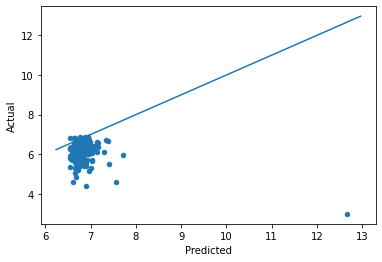

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()
xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

## (B) Nutritional content of different foods

For all the foods you're considering you'll need to be able to describe their nutritional content, in terms that allow you to compare with recommended daily allowances.

## (B) Engel's Law

Explore the validity of Engel's Law (the proposition that the share of food in a household's budget falls with the overall size of the budget) in the context of our population.

## (B) Nutritional adequacy of diet

Given the food actually consumed in your data, what can you say about the adequacy of the diets in the population you're studying? What proportion of households consume enough so that members will exceed dietary recommendations? What proportion do not?

## (C) Counterfactual Experiments

If everyone's total food expenditures doubled (holding prices fixed) how would this affect nutrition in the population? What if relative food prices changed? Think of other counterfactual experiments that might be interesting.